# Face Mask Detection Classsifier

During the COVID-19 pandemic, we have come to realize the importance of using face masks to limit the spread of the virus.

Being able to identify places with high concentration of people not wearing a mask  in advance, will allow hospitals and governments to prepare and allocate resources ahead of time.

This project aims to build a model which takes images of crowds and identifies whether or not they wear a mask correctly.

The input data for this project is a set of images (853) along with an annotations file. Each image may include more than one person, and the annotations file contains general information about the image, as well as the coordinates of each face and its label.

This data includes 3 labels - With mask; Without mask; Mask worn incorrectly.

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # image plotting
import os

The input data includes two files - an image- which is available in the **images** folder, and annotations file which is available in the **annotations** folder. The name of each image and its corresponding annotation file is the same, except for the suffix.

In [3]:
input_data_path = './datasetCNN/images'
annotations_path = "./datasetCNN/annotations"
images = [*os.listdir("./datasetCNN/images")]
output_data_path =  '.'


FileNotFoundError: [Errno 2] No such file or directory: './datasetCNN/images'

## Read the annotations file into a Pandas DataFrame

In [38]:
import xml.etree.ElementTree as ET # is used to parse an XML (inherently hierarchical) data format, which is the format of the annotations file

def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result   


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [39]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

# Since the output of the parse_annotation function is a list of lists, we need to flatten the ctopped faces.
# i.e make it a list of images instead of a list of lists.
full_dataset = sum(dataset, []) # 
#full_dataset

df = pd.DataFrame(full_dataset)
df.shape


(4072, 9)

In [40]:
df.head()


,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss80,400,226,3,with_mask,214,54,291,132
1,maksssksksss128,301,400,3,without_mask,93,183,194,295
2,maksssksksss322,301,400,3,with_mask,60,100,186,253
3,maksssksksss318,400,226,3,with_mask,315,59,337,88
4,maksssksksss318,400,226,3,with_mask,212,52,240,80


### Omit one image from the dataset in order to use it at the end of the project for illustrating the results of the model

In [41]:
final_test_image = 'maksssksksss0' # chose the image
df_final_test = df.loc[df["file"] == final_test_image] # create a separate dataframe which contain only the people in this specific image
images.remove(f'{final_test_image}.png') # remove the image from the full dataset
df = df.loc[df["file"] != final_test_image] # remove the information of the image from the full dataset


In [42]:
df_final_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
30,maksssksksss0,512,366,3,without_mask,79,105,109,142
31,maksssksksss0,512,366,3,with_mask,185,100,226,144
32,maksssksksss0,512,366,3,without_mask,325,90,360,141


In [44]:
# df_final_test = pd.read_csv("dataset_convertido.csv")

# df_final_test.head()

### Rename some columns


In [47]:
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)

### Plot the label distribution in the data

In [48]:
df["label"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: label, dtype: int64

Text(0, 0.5, 'Label')

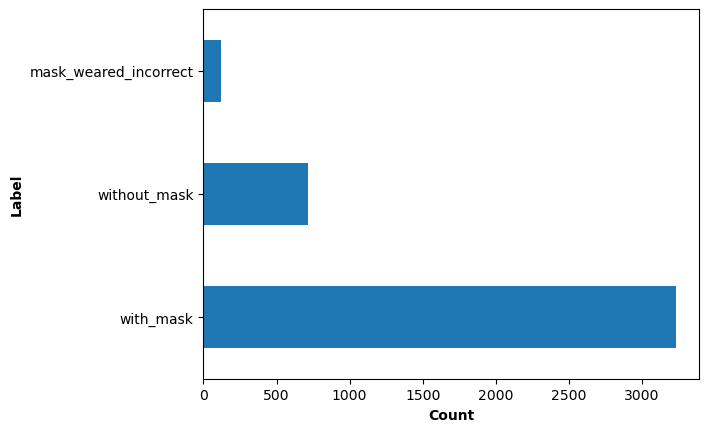

In [50]:
df["label"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Label', fontsize = 10, fontweight = 'bold')

As shown above, we have to deal with an unbalanced dataset. The appropriate solution for this kind of problem (where this distribution reflects the distribution in reality) is to split the data in a way that this distribution will be preserved in the train / test / validation sets. 

## Prepare the data

The next goal is to rearrange our data in new folders, according to their label. We first create an empty folder for each data set (train/ test/ validation) and for each of the 3 labels.

In [49]:
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)

Since each original image may contain multiple faces, we will need to crop all the faces from each image, based on the given coordinates, and copy them to the appropriate folder based on the label of each person. By that, we will recieve a dataset where each image consists of only one face + it's label. 

We will divide these steps into multiple functions. The following function will crop the image based on the given coordinates. We added a small shift (10% of the face size ) in both X and Y directions in order to include more data in each image. 

In [51]:
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):
    
    '''
     This function takes an image path + x and y coordinates of two opposite corners of the rectangle 
     and returns a cropped image
    '''
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

The next function extracts all the people from each image

In [52]:
def extract_faces(image_name, image_info):
    
    '''
     This function takes an image name + dataframe with information about the image 
     and splits the image into all the different faces. image name contains the 
     upper-left coordinate of each face so we could distinguish it later
    '''
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

We now apply the `extract_faces` function on our data set

In [53]:
cropped_faces = [extract_faces(img, df) for img in images]

Since the output of the `extract_faces` function is a list of lists, we need to flatten the cropped faces. i.e make it a list of images instead of a list of lists.

In [54]:
#flat_cropped_faces = [item for sublist in cropped_faces for item in sublist]
flat_cropped_faces = sum(cropped_faces, [])
#flat_cropped_faces

Sort the images into their labels according to our 3 classes. 

In [ ]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

Sanity check

In [ ]:
print(f'num of images with mask: {len(with_mask)}')
print(f'num of images without mask: {len(without_mask)}')
print(f'num of images incorrect mask: {len(mask_weared_incorrect)}')
print(f'sum: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

num of images with mask: 3231
num of images without mask: 715
num of images incorrect mask: 123
sum: 4069


We now split the full data set into train (80%) and test (20%) sets. The test set is split again to test (30%) and validation (70%) sets. 

In [ ]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [ ]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    '''
     This function takes an image name + a path of output folder
     and saves image into the output folder
    '''

    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)   

Save each image in the correct folder 

In [ ]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
    
# Val set
    
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')


# Model Building - CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 17, 17, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)        

### Plotting the model architecture

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


For convenience, we would like to define here some constant parameters  


In [74]:
batch_size = 8
epochs = 50

To enhance our model performance, we would like to add more data to train on. We will use data augmantation to artificially create more data samples.

To do that, we will use the Keras `ImageDataGenerator`. This tool allows us to create new trainning images by manipulating the exiting ones (scaling, rotating, flipping, etc.). However, since not all manipulations make sense in the context of face image, i.e. flipping a face vertically is not a valid option for a person walking down the street , we will only use a small subset of the possible manipulations.

In [75]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='./train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='./val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='./test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [76]:
data_size = len(train_generator) 
#data_size2 = train_generator.n

#print(f"data_size: {data_size}, {data_size2}")

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
#print(f"val size: {len(val_generator)}")
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [77]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics="accuracy"
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)
#model.optimizer.lr=0.001

## Early Stopping

Before training the network, we define an early stopping criterion, to avoid redundent epochs once the model has already converged.

In [78]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

## Reduce Learning Rate On Plateau
We define a `ReduceLROnPlateau` callback to reduce the learning rate when the metric we chose (`val_loss`) has stopped improving.

In [79]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)


In [80]:
# Fit the model on train data

model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

Epoch 1/50


/home/josejoao/anaconda3/envs/DAA/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


50/50 [==============================] - 5s 87ms/step - loss: 0.5862 - accuracy: 0.8025 - recall: 0.7825 - precision: 0.8109 - auc: 0.9106 - val_loss: 0.5345 - val_accuracy: 0.8056 - val_recall: 0.8056 - val_precision: 0.8056 - val_auc: 0.9308 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 4s 69ms/step - loss: 0.4054 - accuracy: 0.8425 - recall: 0.8200 - precision: 0.8586 - auc: 0.9559 - val_loss: 0.4697 - val_accuracy: 0.8194 - val_recall: 0.8194 - val_precision: 0.8310 - val_auc: 0.9423 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 4s 85ms/step - loss: 0.3425 - accuracy: 0.8945 - recall: 0.8769 - precision: 0.9089 - auc: 0.9660 - val_loss: 0.3689 - val_accuracy: 0.9028 - val_recall: 0.8472 - val_precision: 0.8971 - val_auc: 0.9695 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 4s 86ms/step - loss: 0.3361 - accuracy: 0.8800 - recall: 0.8700 - precision: 0.8969 - auc: 0.9687 - val_loss: 0.1730 - val_accuracy: 0.9722 - val_recall: 0

In [81]:
# Evaluate model performance on test data
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (recall*100, precision*100, auc*100))

31/31 [==============================] - 1s 21ms/step - loss: 0.2863 - accuracy: 0.9053 - recall: 0.8930 - precision: 0.9234 - auc: 0.9772
Model has a loss of 0.29 and accuracy 90.53%
Model has a recall of 89.30%, precision of 92.34% and auc of 97.72%


In [82]:
predictions = model.predict(test_generator)
print("predictions shape:", predictions.shape)

31/31 [==============================] - 1s 17ms/step
predictions shape: (243, 3)


In [83]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')


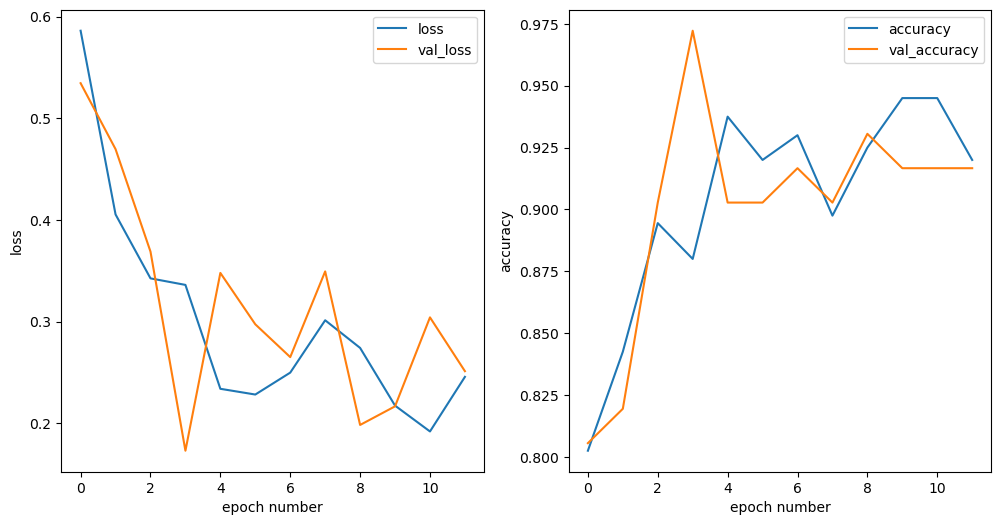

In [84]:
plot_loss_and_accuracy(model_history.history)

In [85]:
model.save('saved_model/modeloCNN')

INFO:tensorflow:Assets written to: saved_model/modeloCNN/assets


INFO:tensorflow:Assets written to: saved_model/modeloCNN/assets


### Randomly choose one image from the test set and examine the difference between the original labeling and the model prediction  

Class Predicted: with_mask , True label: with_mask


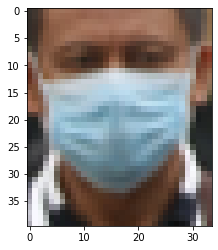

In [ ]:
import cv2

paths = test_generator.filenames # Your files path

y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label}')


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

import seaborn as sns 

def evaluation(y, y_hat, title = 'Confusion Matrix'):
    """Evaluation function
    Prints Classification reports and confusion matrix
    """
    cm = confusion_matrix(y, y_hat)
#     precision = precision_score(y, y_hat)
#     recall = recall_score(y, y_hat)
#     accuracy = accuracy_score(y,y_hat)
#     f1 = f1_score(y,y_hat)
#     report = classification_report(y,y_hat)
#     print(report)
#     print('Recall: ', recall)
#     print('Accuracy: ', accuracy)
#     print('Precision: ', precision)
#     print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

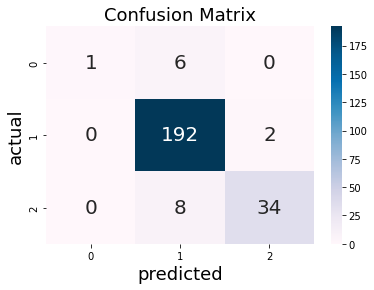

In [ ]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

In [ ]:
classes

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

In [ ]:
np.bincount(y_pred) # Use bincount() to count occurrences of each class in a predictions NumPy array

array([  1, 206,  36])

# Testing the Results

In [2]:
import cv2
import os

img = cv2.imread(os.path.join(input_data_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
# mask_label = {"face_with_mask":0, "face_no_mask":1 , "face_with_mask_incorrect":2}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]
#df_test_img
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)


NameError: name 'input_data_path' is not defined

# Avaliação com os nossos dados de teste

In [52]:
import pandas as pd
import cv2
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def output_label(label):
    output_mapping = { 2:"face_with_mask", 1:"face_no_mask" , 0:"face_with_mask_incorrect"}
    return output_mapping[label]




df = pd.read_csv('./test.csv')

image_folder = './imagesResized'



def process_image(image_path, x_min, x_max, y_min, y_max):
    img = cv2.imread(image_path)
   
    if 'face_with_mask_incorrect' in image_path:
            resized_face = cv2.resize(img, (35, 35))
    else:
            resized_face = cv2.resize(img[y_min:y_max, x_min:x_max], (35, 35))
        
    reshaped_face = np.reshape(resized_face, [1, 35, 35, 3]) / 255.0

    return reshaped_face


new_model = tf.keras.models.load_model('saved_model/modeloCNN')


preds = []
true_labels = []

tot_imgs = 0

for index, row in df.iterrows():

    file_path = os.path.join(image_folder, row['name'])
    tot_imgs += 1
    
   
    try:
        img = process_image(file_path, row['x1'], row['x2'], row['y1'], row['y2'])
        true_class = row['classname']
        face_result = new_model.predict(img)
        
        # mapear pq o modelo foi treinado com as classes invertidas as que nos usamos
        # if face_result.argmax() == 0:
        #     pred_class = 2
        # elif face_result.argmax() == 1:
        #     pred_class = 0
        # elif face_result.argmax() == 2:
        #     pred_class = 1
        # print("file: ", row['name'], "face_result: ", pred_class, "true_class: ", true_class)

        pred_class = output_label(face_result.argmax())

        preds.append(pred_class)
        true_labels.append(true_class)
    except:
         pass



1/1 [==============================] - 0s 41ms/step


In [53]:
print(preds)
print(true_labels)

['face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_with_mask', 'face_no_mask', 'face_no_mask', 'face_with_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_with_mask', 'face_no_mask', 'face_with_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_with_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_with_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_mask', 'face_no_ma

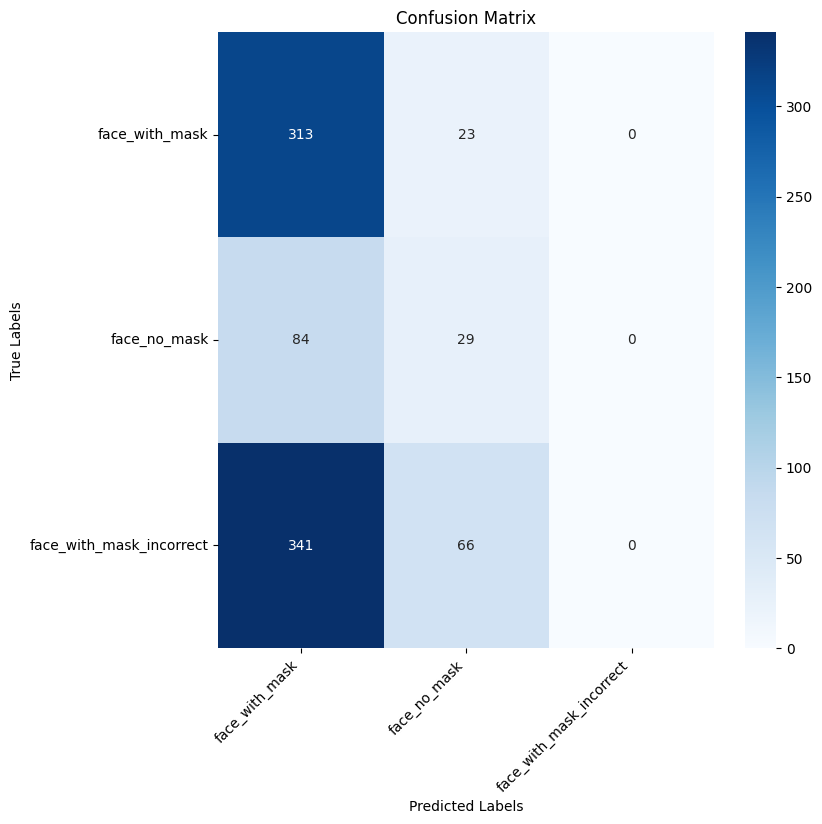

In [56]:
cm = confusion_matrix(true_labels, preds)

# Creating a figure and axes to plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

# Plotting the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

# Setting axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

# Setting x and y axis tick labels
ax.xaxis.set_ticklabels(["face_with_mask","face_no_mask" ,"face_with_mask_incorrect"], rotation=45, ha='right')
ax.yaxis.set_ticklabels(["face_with_mask","face_no_mask" ,"face_with_mask_incorrect"], rotation=0)

# Displaying the plot
plt.show()


In [55]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, preds)

print("Accuracy:", accuracy)

Accuracy: 0.39953271028037385
